In [1]:
from astropy.io.fits import getdata
from astropy.cosmology import Planck13
import astropy.constants as const
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get Database Contents for halo properties (200m and 500c)
import L500analysis.caps.io.reader as db
sim = db.Simulation('L500_NR_0',db_dir='../../L500analysis/simulation_databases/'
                  )
halo_props=sim.get_halo_properties([1,104],['r200m','r500c','M_total_200m','M_total_500c'],'1.0005')
print halo_props

looking in ../../L500analysis/simulation_databases/ for L500_NR_0.db
    id     r200m    r500c  M_total_200m  M_total_500c
0    1  2395.287  887.308  8.612500e+14  4.058300e+14
1  104  2346.400  819.107  8.095900e+14  3.192600e+14


In [3]:
halo_props['M_total_500c'][halo_props['id']==104]

1    3.192600e+14
Name: M_total_500c, dtype: float64

In [4]:
# Constants
kb = const.k_B.cgs.value # erg/K
m2cm = 100 # cm/m
Msun2g = const.M_sun.cgs.value # g/Msun
kpc2cm = const.kpc.cgs.value # cm/kpc
Mpc2cm = kpc2cm * 1/1000 
sigT = 6.65245873*10**(-29) * m2cm * m2cm # cm^2
me = const.m_e.cgs.value # g
c = const.c.cgs.value # cm/s
h = Planck13.h
rhocrit = Planck13.critical_density0.value # g/cm^3
Tcmb = Planck13.Tcmb0.value # K
Om0 = Planck13.Om0 * rhocrit # g/cm^3 
G = const.G.cgs.value 
Lvmax = 8
kpchperpix=3.6
dA = { z: Planck13.angular_diameter_distance(z).value * Mpc2cm for z in [0, 1] }

In [5]:
Planck13.h

0.6777

In [6]:
def get_T_rho(Tfile, rhofile, aexp=1.0) :
    return getdata(Tfile), getdata(rhofile)*(Om0/aexp)

In [7]:
T1, rho1 = get_T_rho('../data/temperature_a1.0005_CL1_N256_Lv6.fits',
                     '../data/rhogas_a1.0005_CL1_N256_Lv6.fits')

In [8]:
T104, rho104 = get_T_rho('../data/temperature_a1.0005_CL104_N256_Lv6.fits',
                         '../data/rhogas_a1.0005_CL104_N256_Lv6.fits')

In [9]:
T13z1, rho13z1 = get_T_rho('../data/temperature_a0.5014_CL13_N256_Lv5.fits',
                               '../data/rhogas_a0.5014_CL13_N256_Lv5.fits')

In [10]:
def calculate_T500(M500c, R500c) :
    return G*M500c/(2*R500c)

In [11]:
def calculate_ysz(ne, Te) :
    return ne * kb * Te * sigT / (me * c**2)

In [12]:
def YSZ( ysz, aexp=1.0, Lv=6.) :
    # YSZ from each cube
    dA = Planck13.angular_diameter_distance(1./aexp - 1.)
    # level and redshift dependent volume element
    Lv_width = kpchperpix * kpc2cm * 2**(Lvmax - Lv) / h
    dV = Lv_width * Lv_width * Lv_width
    return (1/dA**2) * ysz * dV

In [13]:
def calculate_Tsz_freq_dependence(nu) :
    x = h*nu / (kb * Tcmb)
    return x * (np.exp(x)+1.)/(np.exp(x)-1.) - 4.

In [14]:
ysz104 = calculate_ysz( rho104, T104 )
ysz1 = calculate_ysz( rho1, T1 )

In [15]:
ysz13z1 = calculate_ysz( rho13z1, T13z1 )

In [16]:
print halo_props['r500c']
print halo_props['r200m']
print 3.8 * 4. *256./2.

0    887.308
1    819.107
Name: r500c, dtype: float64
0    2395.287
1    2346.400
Name: r200m, dtype: float64
1945.6


In [17]:
T500_104 = calculate_T500(halo_props['M_total_500c'][halo_props['id']==104],halo_props['r500c'][halo_props['id']==104])
T500_1 = calculate_T500(halo_props['M_total_500c'][halo_props['id']==1],halo_props['r500c'][halo_props['id']==1])


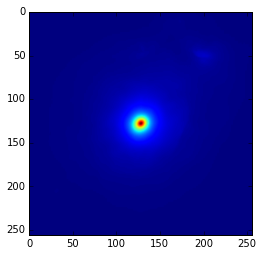

In [18]:
plt.imshow(ysz104.sum(axis=0))

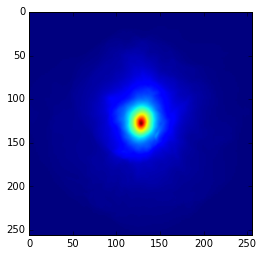

In [19]:
plt.imshow(ysz1.sum(axis=0))

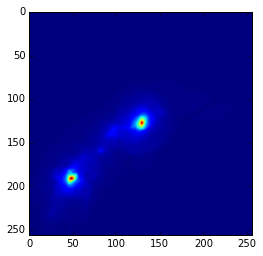

In [20]:
plt.imshow(ysz13z1.sum(axis=0))

In [21]:
def collect_shell_min_max_indices(r_min, r_max, cube_dist, r_units='r500c',halo_id=1,Lv=6, kpchperpix=3.6, cells_per_cube=256) :
    '''Returns a np.where statement for the cube'''
    r_scale = float(halo_props[r_units][halo_props['id']==halo_id]) * kpc2cm / h
    Lv_width = kpchperpix * kpc2cm * 2**(Lvmax - Lv) / h
    # compute min/max in terms of cell width
    r_min *= r_scale / Lv_width
    r_max *= r_scale / Lv_width
    return np.where( (cube_dist >= r_min)  &  (cube_dist <= r_max) ) 

In [22]:
def compute_cell_3d_distance_from_center(cells_per_cube=256) :
    '''For a 3x3 cube, should look like
    sqrt(5)  sqrt(2)  sqrt(5) | sqrt(2) 1  sqrt(2)  |  sqrt(5)  sqrt(2)  sqrt(5)
    sqrt(2)  1        sqrt(2) | 1       0  1        |  sqrt(2)  1        sqrt(2)
    sqrt(5)  sqrt(2)  sqrt(5) | sqrt(2) 1  sqrt(2)  |  sqrt(5)  sqrt(2)  sqrt(5)
    '''
    cube = []
    for i in np.arange(-1*(cells_per_cube-1)/2., (cells_per_cube-1)/2.+1,1.) :
        for j in np.arange(-1*(cells_per_cube-1)/2., (cells_per_cube-1)/2.+1,1.) :
            for k in np.arange(-1*(cells_per_cube-1)/2., (cells_per_cube-1)/2.+1,1.) :
                cube.append(np.sqrt(i**2+j**2+k**2))
    return np.array(cube).reshape(cells_per_cube,cells_per_cube,cells_per_cube)

In [23]:
test_cube = []
for i in np.arange(-1,2) :
    for j in np.arange(-1,2) :
        for k in np.arange(-1,2) :
            test_cube.append(np.sqrt(i**2+j**2+k**2))
test_cube = np.array(test_cube).reshape(3,3,3)
np.all(compute_cell_3d_distance_from_center(3)==test_cube)

NameError: name 'np' is not defined

In [ ]:
def compute_cell_2d_distance_from_center(cells_per_cube=256) :
    '''For a 2x2 cube, should look like
    sqrt(2) 1  sqrt(2)
    1       0  1      
    sqrt(2) 1  sqrt(2)
    '''
    square = []
    for i in np.arange(-1*(cells_per_cube-1)/2., (cells_per_cube-1)/2.+1,1.) :
        for j in np.arange(-1*(cells_per_cube-1)/2., (cells_per_cube-1)/2.+1,1.) :
                square.append(np.sqrt(i**2+j**2))
    return np.array(square).reshape(cells_per_cube,cells_per_cube)

In [ ]:
test_square = []
for i in np.arange(-1,2) :
    for j in np.arange(-1,2) :
        test_square.append(np.sqrt(i**2+j**2))
test_square = np.array(test_square).reshape(3,3)
np.all(compute_cell_2d_distance_from_center(3)==test_square)

In [ ]:
from SZmaps.utils import files
# pre-computed from compute_cell_?d_distance_from_center()
distance_3d = files.load_pkl('../samples/distance_3d.pkl')
distance_2d = files.load_pkl('../samples/distance_2d.pkl')

In [ ]:
sphere_indices_r500c = collect_shell_min_max_indices(1, 1.5, distance_3d, halo_id=1 )

In [ ]:
sphere_indices_r200c = collect_shell_min_max_indices(.66, 1., distance_3d, halo_id=1 )

In [ ]:
ysz1[sphere_indices_r200c].sum()